# Import modules
Run 1st.

In [1]:
from __future__ import print_function
from __future__ import division

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import copy
import time
import skimage

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision
from torchvision import transforms, datasets, models
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

np.random.seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PyTorch Version:  1.0.1.post2
Torchvision Version:  0.2.2


# Define Deep Learning model
Run 2nd.

### ResNet

In [ ]:
import math
import torch.utils.model_zoo as model_zoo


# __all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
#            'resnet152']


# model_urls = {
#     'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
#     'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
#     'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
#     'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
#     'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
# }


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        ###
        ### change 3 to 4 for our data
        ###
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False) # changed to 4
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model



def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model



def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model



def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model



def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model

### classic AlexNet

In [ ]:
class classicAlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(classicAlexNet, self).__init__()
        ###
        ### Changed 3 to 4 to fit our data dimension sieze
        ###
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x


def alexnet(pretrained=False, progress=True, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = classicAlexNet(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


### modified AlexNet by Paper (kddTC)

In [2]:
'''
Notice data fed to kddTC should follow the pre-processing steps by the paper
Especially, (1) only two channels should be included;
(2) middle cropping;
(3) rotation?
'''
class kddAlex(nn.Module):

    def __init__(self, num_outputs = 1):
        super(kddAlex, self).__init__()
        ###
        ### Changed 3 to 2 to fit our data dimension sieze
        ###
        self.features = nn.Sequential(
            # nn.Conv2d(2, 64, kernel_size=11, stride=4, padding=2),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(2, 16, kernel_size=4, stride=2),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3, stride=2),
        )
        # self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            # nn.Dropout(),
            nn.Linear(128 * 3 * 3, 256),
            nn.ReLU(inplace=True),
            # nn.Dropout(),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_outputs),
        )

    def forward(self, x):
        x = self.features(x)
        # x = self.avgpool(x)
        x = x.view(x.size(0), 128 * 3 * 3)
        x = self.classifier(x)
        return x


def kddTC(pretrained=False, progress=True, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = kddAlex(**kwargs)
    # if pretrained:
    #    state_dict = load_state_dict_from_url(model_urls['alexnet'],
    #                                          progress=progress)
    #    model.load_state_dict(state_dict)
    return model


# Training set mean and variance per channel

In [ ]:
data_path = "TCIR-ALL_2017.h5"

# load "info" as pandas dataframe
data_info = pd.read_hdf(data_path, key="info", mode='r')

# load "matrix" as numpy ndarray, this could take longer times
with h5py.File(data_path, 'r') as hf:
    data_matrix = hf['matrix'][:]

In [ ]:
data_matrix.reshape(-1, 4).mean(axis = 0)

In [ ]:
skimage.transform.rotate(data_matrix[0, :, :, :], 10).shape

In [ ]:
plt.hist(data_matrix[0, :, :, 0].flatten(), 100)
plt.show()

In [ ]:
plt.hist(skimage.transform.rotate(data_matrix[0, :, :, 0], 1, preserve_range=True).flatten(), 100)
plt.show()

In [ ]:
import scipy
plt.hist(scipy.ndimage.rotate(data_matrix[0, :, :, 0], 1).flatten(), 100)
plt.show()

In [ ]:
plt.imshow(data_matrix[0, :, :, 0], cmap='gray')
plt.show()

In [ ]:
plt.imshow(skimage.transform.rotate(data_matrix[0, :, :, 0], 90, preserve_range=True), cmap='gray')
plt.show()

In [ ]:
np.max(data_matrix[0, :, :, 0])

In [ ]:
np.max(skimage.transform.rotate(data_matrix[0, :, :, 0], 10, preserve_range=True))

## Print shape
Must deal with data outlier as proposed in paper

In [ ]:
np.prod(data_matrix.shape)

In [ ]:
count = 0
for i in range(data_matrix.shape[0]):
    if np.count_nonzero(np.isnan(data_matrix[i, :, :, :])) > 0:
        count += 1
print(count)
print(data_matrix.shape[0])

## A sketch of label matrix
Vmax is wind speed, MSLP is minimum sea level pressure, R35_4qAVG is radius.

In [ ]:
data_info

## Several visualizations

In [ ]:
plt.plot(data_info.loc[data_info['ID'] == '201733W']['Vmax'])
plt.show()

In [ ]:
plt.imshow(data_matrix[0,:,:,0], cmap='gray')
plt.show()

In [ ]:
plt.imshow(data_matrix[1,:,:,0], cmap='gray')
plt.show()

In [ ]:
plt.imshow(data_matrix[2,:,:,0], cmap='gray')
plt.show()

In [ ]:
plt.imshow(data_matrix[10,:,:,0], cmap='gray')
plt.show()

# Try a model with Pytorch API

### Check h5df file
Don't run.

In [ ]:
def h5printR(item, leading = ''):
    for key in item:
        if isinstance(item[key], h5py.Dataset):
            print(leading + key + ': ' + str(item[key].shape))
        else:
            print(leading + key)
            h5printR(item[key], leading + '  ')

# Print structure of a `.h5` file            
def h5print(filename):
    with h5py.File(filename, 'r') as h:
        print(filename)
        h5printR(h, '  ')

In [ ]:
file_path = 'TCIR-ALL_2017.h5'
h5_file = h5py.File(file_path)
matrix = h5_file.get('matrix')
target = h5_file.get('info') #/block0_values

In [ ]:
list(target['block0_items'])

In [ ]:
h5print('TCIR-ALL_2017.h5')

In [ ]:
datMatrix = torch.from_numpy(matrix[:, 68 : 68 + 64, 68 : 68 + 64, [0,3]]).permute(0, 3, 1, 2).float()
datMatrix = np.nan_to_num(datMatrix)
datMatrix[datMatrix > 1000] = 0

In [ ]:
np.count_nonzero(np.isnan(datMatrix))

## Continue: data load, model train
+ **Run 3rd**.<br>
+ Dimension does not match. Pytorch defaults to $N\times C\times H\times W$, while our data comes in $N\times H\times W\times C\$. Use **permute()** to swap axis. <br>
+ Next, we have four channels while resnet only accepts 3

In [3]:
class kddTCData(data.Dataset):

    def __init__(self, file_path, transform=None):
        super(kddTCData, self).__init__()
        h5_file = h5py.File(file_path)
        self.data = h5_file.get('matrix')
        # hard code the Vmax label
        self.target = h5_file.get('info/block0_values')[:,2]
        self.transform = transform

    def __getitem__(self, index):
        # middle crop and permute axis
        datMatrix = torch.from_numpy(self.data[index, 68 : (68 + 64), 68 : (68 + 64), [0,3]]).permute(2, 0, 1).float()
        # datMatrix = (datMatrix - datMatrix.mean(axis=0)) / datMatrix.std(axis=0)
        labMatrix = torch.from_numpy(self.target)[index].float()
        # replace nan with 0
        datMatrix = np.nan_to_num(datMatrix)
        # replace extremely large values with 0
        datMatrix[datMatrix > 1000] = 0
        return (datMatrix, labMatrix)

    def __len__(self):
        return self.data.shape[0]
    
    def length(self):
        return self.data.shape[0]

In [4]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, is_inception=False):
    since = time.time()
    
    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    # best_acc = 0.0
    best_loss = float("inf")

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            # running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        # print(outputs)
                        loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                # running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            print(phase, len(dataloaders[phase].dataset))
            # epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            # print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_loss_history, train_loss_history

In [5]:
def learn(model, data_source, batch_size, num_epochs):
    dataDic = {
        '2017': 'TCIR-ALL_2017.h5',
        'c-i-sh': 'TCIR-CPAC_IO_SH.h5',
        'a-e-w':'TCIR-ATLN_EPAC_WPAC.h5'
    }
    transf = {
        '2017': {'mean': None, 'std': None},
        'c-i-sh': {'mean': None, 'std': None}, 
        'a-e-w': {'mean': None, 'std': None}
    }
    data_transform = transforms.Normalize(mean=transf[data_source]['mean'], std=transf[data_source]['std'])
    data = kddTCData(dataDic[data_source],
                         transform = data_transform)
    
    NUM_DATA = data.length()
    print(NUM_DATA)
    dataloaders = {}
    dataloaders['train'] = DataLoader(data, batch_size=batch_size, 
                              sampler=sampler.SubsetRandomSampler(range(int(NUM_DATA * 0.7))),
                             num_workers=4)
    dataloaders['val'] = DataLoader(data, batch_size=batch_size, 
                            sampler=sampler.SubsetRandomSampler(range(int(NUM_DATA * 0.7), NUM_DATA)),
                            num_workers=4)
    
    model = model.to(device)

    criterion = nn.MSELoss()

    # Observe that all parameters are being optimized
    # optim.SGD(kdd18.parameters(), lr=0.001, momentum=0.9)
    model_optmzer = optim.Adam(model.parameters(), lr=0.00002)

    model, val_loss_history, train_loss_history = train_model(model, dataloaders, criterion, 
                           model_optmzer, num_epochs=num_epochs)
    return model, val_loss_history, train_loss_history

In [6]:
kdd18 = kddTC(pretrained=False)
_, val_loss, train_loss = learn(kdd18, 'c-i-sh', batch_size = 64, num_epochs = 20)

23118
Epoch 0/19
----------
train Loss: 797.9019
val Loss: 235.9215

Epoch 1/19
----------
train Loss: 539.3638
val Loss: 238.1276

Epoch 2/19
----------
train Loss: 538.2669
val Loss: 235.1589

Epoch 3/19
----------
train Loss: 537.9621
val Loss: 235.1429

Epoch 4/19
----------
train Loss: 537.0011
val Loss: 235.1195

Epoch 5/19
----------
train Loss: 534.5510
val Loss: 235.8191

Epoch 6/19
----------
train Loss: 534.2736
val Loss: 239.8773

Epoch 7/19
----------
train Loss: 533.5470
val Loss: 237.7499

Epoch 8/19
----------
train Loss: 532.5983
val Loss: 245.3387

Epoch 9/19
----------
train Loss: 531.8875
val Loss: 236.0955

Epoch 10/19
----------
train Loss: 532.6863
val Loss: 234.4076

Epoch 11/19
----------
train Loss: 532.0000
val Loss: 233.6511

Epoch 12/19
----------
train Loss: 530.7246
val Loss: 237.6955

Epoch 13/19
----------
train Loss: 529.5785
val Loss: 238.4636

Epoch 14/19
----------
train Loss: 528.5593
val Loss: 237.4007

Epoch 15/19
----------
train Loss: 528.6522


### Plot

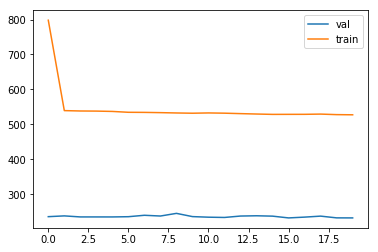

In [7]:
plt.plot(val_loss, label = 'val')
plt.plot(train_loss, label = 'train')
plt.legend()
plt.show()

### ResNet

In [ ]:
resnet = resnet34(pretrained=False)
num_ftrs = resnet.fc.in_features
num_output = 1
resnet.fc = nn.Linear(num_ftrs, num_output)

resnet = resnet.to(device)

criterion = nn.MSELoss()

# Observe that all parameters are being optimized
resnet_optmzer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

resnet = train_model(resnet, dataloaders, criterion, 
                       resnet_optmzer, num_epochs=1)